In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('float_format', '{:f}'.format)
import numpy as np
import time
import os
import joblib

# models to test
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor

# metrics and tools
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# plot lib
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# warnings handling
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings


In [2]:
#data = pd.read_csv('nouveaux_datasets/df_model_left_221201.csv')
data = pd.read_csv('nouveaux_datasets/df_model_inner_221201.csv')
data.head(10)

C:\Users\Christophe\AppData\Local\Temp\ipykernel_18348\4292129304.py:2: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('nouveaux_datasets/df_model_inner_221201.csv')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,index,valeur_fonciere,adresse_numero,adresse_nom_voie,nom_commune,id_parcelle,type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,year,month,trim,index_prix,tuple_gps,closest_school_(m),closest_school_position,closest_bakery_(m),closest_bakery_position,closest_supermarket_(m),closest_supermarket_position,closest_metro_(m),closest_metro_position,closest_tram_(m),closest_tram_position,code_postal,adresse,geokey,Unnamed: 0_y,annee_dpe,diag_dpe,type_bat_dpe,annee_construction_dpe,surface_habitable_dpe,num_rue_dpe,rue_dpe,code_postal_dpe,etage_dpe,nbe_niveaux_dpe,orientation_dpe,adresse_dpe
0,0,6,14396,94225,19222288.000000,12.000000,RUE DE LA REPUBLIQUE,Lyon 2e Arrondissement,69382000AB0050,Appartement,24.000000,1.000000,4.835576,45.765109,2019,7,2019-T3,4.000000,"(45.765109, 4.835576)",150.890000,"(45.7654990924134, 4.83371292252651)",195.900000,"(45.7642568003775, 4.8333657)",39.800000,"(45.7650821003774, 4.8360876)",191.720000,"(45.763393, 4.835816)",875.260000,"(45.75888, 4.842474)",69002,12 RUE DE LA REPUBLIQUE,69382_6005_00012,35706,2022,D,appartement,1947.000000,24.500000,12,Rue de la République,69002,5.000000,1.000000,NaN,12 Rue de la République
1,1,7,14393,94222,19222288.000000,12.000000,RUE DE LA REPUBLIQUE,Lyon 2e Arrondissement,69382000AB0050,Appartement,24.000000,1.000000,4.835576,45.765109,2019,7,2019-T3,4.000000,"(45.765109, 4.835576)",150.890000,"(45.7654990924134, 4.83371292252651)",195.900000,"(45.7642568003775, 4.8333657)",39.800000,"(45.7650821003774, 4.8360876)",191.720000,"(45.763393, 4.835816)",875.260000,"(45.75888, 4.842474)",69002,12 RUE DE LA REPUBLIQUE,69382_6005_00012,35706,2022,D,appartement,1947.000000,24.500000,12,Rue de la République,69002,5.000000,1.000000,NaN,12 Rue de la République
2,2,28,14394,94223,19222288.000000,12.000000,RUE DE LA REPUBLIQUE,Lyon 2e Arrondissement,69382000AB0050,Appartement,32.000000,1.000000,4.835576,45.765109,2019,7,2019-T3,4.000000,"(45.765109, 4.835576)",150.890000,"(45.7654990924134, 4.83371292252651)",195.900000,"(45.7642568003775, 4.8333657)",39.800000,"(45.7650821003774, 4.8360876)",191.720000,"(45.763393, 4.835816)",875.260000,"(45.75888, 4.842474)",69002,12 RUE DE LA REPUBLIQUE,69382_6005_00012,35706,2022,D,appartement,1947.000000,24.500000,12,Rue de la République,69002,5.000000,1.000000,NaN,12 Rue de la République
3,3,39,14395,94224,19222288.000000,12.000000,RUE DE LA REPUBLIQUE,Lyon 2e Arrondissement,69382000AB0050,Appartement,36.000000,2.000000,4.835576,45.765109,2019,7,2019-T3,4.000000,"(45.765109, 4.835576)",150.890000,"(45.7654990924134, 4.83371292252651)",195.900000,"(45.7642568003775, 4.8333657)",39.800000,"(45.7650821003774, 4.8360876)",191.720000,"(45.763393, 4.835816)",875.260000,"(45.75888, 4.842474)",69002,12 RUE DE LA REPUBLIQUE,69382_6005_00012,35706,2022,D,appartement,1947.000000,24.500000,12,Rue de la République,69002,5.000000,1.000000,NaN,12 Rue de la République
4,4,8,14491,94511,22982264.000000,10.000000,RUE DE LA REPUBLIQUE,Lyon 1er Arrondissement,69381000AV0079,Appartement,29.000000,1.000000,4.835730,45.765498,2019,9,2019-T3,4.000000,"(45.765498, 4.83573)",142.360000,"(45.7652058788412, 4.8375167949069)",186.520000,"(45.7661227003772, 4.8334984)",53.430000,"(45.7653965003773, 4.8364032)",234.160000,"(45.763393, 4.835816)",902.900000,"(45.75888, 4.842474)",69001,10 RUE DE LA REPUBLIQUE,69381_6005_00010,32486,2022,C,appartement,1947.000000,114.700000,10,Rue de la République,69001,4.000000,1.000000,NaN,10 Rue de la République
5,5,51,14487,94506,22982264.000000,10.000000,RUE DE LA REPUBLIQUE,Lyon 1er Arrondissement,69381000AV0079,Appartement,44.000000,2.000000,4.835730,45.765498,2019,9,2019-T3,4.000000,"(45.765498, 4.83573)",142.360000,"(45.7652058788412, 4.8375167949069)",186.520000,"(45.7661227003772, 4.8334984)",53.430000,"(45.7653965003773, 4.8364032)",234.160000,"(45.763393, 4.835816)",902.900000,"(45.75888, 4.842474)",69001,10 RUE DE LA REPUBLIQUE,69381_6005_00010,32486,2022,C,app

## FEATURE ENGINEERING + SELECTION + CLEANING

In [3]:
list_diag_dpe_int = []

for value in data['diag_dpe']:
    if value == 'A':
        list_diag_dpe_int.append(6)
    elif value == 'B':
        list_diag_dpe_int.append(5)
    elif value == 'C':
        list_diag_dpe_int.append(4)
    elif value == 'D':
        list_diag_dpe_int.append(3)
    elif value == 'E':
        list_diag_dpe_int.append(2)
    elif value == 'F':
        list_diag_dpe_int.append(1)
    elif value == 'G':
        list_diag_dpe_int.append(0)

data['diag_dpe_int'] = list_diag_dpe_int

In [4]:
list_to_replace_arrdt = []

for value in data['nom_commune']:
    if value == 'Lyon 1er Arrondissement':
        list_to_replace_arrdt.append(1)
    elif value == 'Lyon 2e Arrondissement':
        list_to_replace_arrdt.append(2)
    elif value == 'Lyon 3e Arrondissement':
        list_to_replace_arrdt.append(3)
    elif value == 'Lyon 4e Arrondissement':
        list_to_replace_arrdt.append(4)
    elif value == 'Lyon 5e Arrondissement':
        list_to_replace_arrdt.append(5)
    elif value == 'Lyon 6e Arrondissement':
        list_to_replace_arrdt.append(6)
    elif value == 'Lyon 7e Arrondissement':
        list_to_replace_arrdt.append(7)
    elif value == 'Lyon 8e Arrondissement':
        list_to_replace_arrdt.append(8)
    elif value == 'Lyon 9e Arrondissement':
        list_to_replace_arrdt.append(9)

data['arrdt_int'] = list_to_replace_arrdt

In [5]:
data['prix_metre_carres'] = data['valeur_fonciere'] / data['surface_reelle_bati']
data['log_val_fon'] = data['valeur_fonciere'].apply(lambda x : np.log(x))

In [6]:
print(data.shape)
data = data.drop_duplicates(subset=['adresse_numero','adresse_nom_voie','surface_reelle_bati', 'year', 'month', 'trim'])
print(data.shape)

(32803, 49)
(31215, 49)


In [7]:
surface_max = 185.0
surface_min = 15.0
prix_max = 1200000.0
prix_min = 40000.0
prix_m2_max = 8000.0
prix_m2_mini = 1200.0

data = data[data['surface_reelle_bati'] < surface_max]
data = data[data['surface_reelle_bati'] > surface_min]
data = data[data['valeur_fonciere'] < prix_max]
data = data[data['valeur_fonciere'] > prix_min]
data = data[data['prix_metre_carres']<prix_m2_max]
data = data[data['prix_metre_carres']>prix_m2_mini]

In [8]:
list_categorie = []

for value in data['valeur_fonciere']:
    if value <= 25000.0:
        list_categorie.append('categorie_<=_25k')
    elif value <= 50000.0:
        list_categorie.append('categorie_btw25_and_50k')
    elif value <= 80000.0:
        list_categorie.append('categorie_btw50_and_80k')
    elif value <= 100000.0:
        list_categorie.append('categorie_btw80_and_100k')
    elif value <= 150000.0:
        list_categorie.append('categorie_btw100_and_150k')
    elif value <= 200000.0:
        list_categorie.append('categorie_btw150_and_200k')
    elif value <= 250000.0:
        list_categorie.append('categorie_btw200_and_250k')
    elif value <= 300000.0:
        list_categorie.append('categorie_btw250_and_300k')
    elif value <= 350000.0:
        list_categorie.append('categorie_btw300_and_350k')
    elif value <= 400000.0:
        list_categorie.append('categorie_btw350_and_400k')
    elif value <= 500000.0:
        list_categorie.append('categorie_btw400_and_500k')
    elif value <= 600000.0:
        list_categorie.append('categorie_btw500_and_600k')
    elif value <= 800000.0:
        list_categorie.append('categorie_btw600_and_800k')
    elif value <= 1000000.0:
        list_categorie.append('categorie_btw800_and_1M')
    elif value <= 1200000.0:
        list_categorie.append('categorie_btw1M_and_1M2')
    else:
        list_categorie.append('categorie_>_1.2M')


data['valeur_fonciere_categorie'] = list_categorie

In [9]:
list_m2_categorie = []

for value in data['prix_metre_carres']:
    if value <= 2000.0:
        list_m2_categorie.append('m2_categorie_<=_2k')
    elif value <= 3000.0:
        list_m2_categorie.append('m2_categorie_<=_3k')
    elif value <= 4000.0:
        list_m2_categorie.append('m2_categorie_<=_4k')
    elif value <= 5000.0:
        list_m2_categorie.append('m2_categorie_<=_5k')
    elif value <= 6000.0:
        list_m2_categorie.append('m2_categorie_<=_6k')
    elif value <= 7000.0:
        list_m2_categorie.append('m2_categorie_<=_7k')
    elif value <= 8000.0:
        list_m2_categorie.append('m2_categorie_<=_8k')
    else:
        list_m2_categorie.append('categorie_>_8k')

data['m2_categorie'] = list_m2_categorie

## DBSCAN (cleaning outliers)

In [10]:
#DBScan Start
# beginning of ML for DBscan
numeric_features =['surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude', 'index_prix', 'closest_school_(m)', 'closest_bakery_(m)', 'closest_supermarket_(m)', 'closest_metro_(m)', 'closest_tram_(m)', 'annee_construction_dpe', 'log_val_fon']
categorical_features = ['type_local', 'diag_dpe', 'nom_commune']

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

    # Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])




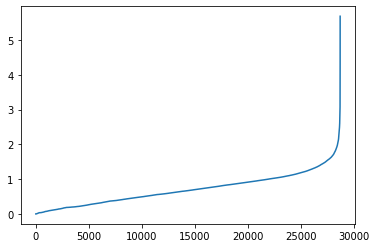

In [11]:
sc_df = preprocessor.fit(data)
dataset = sc_df.transform(data)

neigh = NearestNeighbors()
nbrs = neigh.fit(dataset)
distances, indices = nbrs.kneighbors(dataset)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

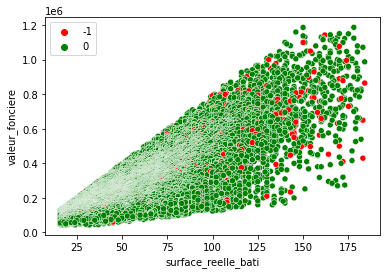

In [12]:


db = DBSCAN(eps = 2.5, min_samples = 30).fit(dataset)

db_predict = db.fit_predict(dataset)

sns.scatterplot(data= data, x= data['surface_reelle_bati'],y= data['valeur_fonciere'], hue = db_predict, palette=["Red", "Green"])

data["cluster"] = db.labels_
data["cluster"].value_counts()
mask = (data["cluster"] == 0)
data = data.loc[mask,:]

In [13]:
data['cluster'].unique()

array([0], dtype=int64)

## MACHINE LEARNING : 
- last training on all data with our best model
- saving our model 

In [14]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ['surface_reelle_bati','longitude', 'latitude', 'nombre_pieces_principales', \
                'type_local', 'year', 'index_prix', 'closest_school_(m)', 'closest_bakery_(m)', \
                'closest_supermarket_(m)', 'closest_metro_(m)', 'closest_tram_(m)', \
                'annee_construction_dpe', 
                'arrdt_int',
                'diag_dpe_int'
                ]
                
target_variable = 'log_val_fon'

X = data.loc[:,features_list]
Y = data.loc[:,target_variable]


Separating labels from features...


In [15]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['surface_reelle_bati', 'longitude', 'latitude', 'nombre_pieces_principales', 'year', 'index_prix', 'closest_school_(m)', 'closest_bakery_(m)', 'closest_supermarket_(m)', 'closest_metro_(m)', 'closest_tram_(m)', 'annee_construction_dpe', 'arrdt_int', 'diag_dpe_int']
Found categorical features  ['type_local']


In [16]:
# Instanciate our ML model

model = XGBRegressor(max_depth=8, min_child_weight=8, n_estimators=66)

In [17]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [18]:
pipe = make_pipeline(preprocessor, model)
pipe.fit(X, Y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'longitude', 'latitude',
                                                   'nombre_pieces_principales',
                                                   'year', 'index_prix',
                                                   'closest_school_(m)',
                                                   'closest_bakery_(m)',
                                                   'closest_supermarket_(m)',
                                                   'closest_metro_(m)',
                                                   'closest_tram_(m)'...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=8, max_leaves=0, min_child_weight=8,
                              missing=nan, monotone_constraints='()',
                              n_estimators=66, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

## SAVE the pipeline (preprocessing + model) to file

In [19]:

timestr = time.strftime("%Y%m%d-%H%M%S")
# Directory
directory = f"{timestr}"
# Parent Directory path
parent_dir = "model_recorded/"
# Path
path = os.path.join(parent_dir, directory)
os.mkdir(path)
# name of the model
name_model = pipe.__dict__['steps'][1][0]
# save our joblib file
joblib.dump(pipe, f'{path}/{timestr}-{name_model}.joblib')

['model_recorded/20221216-123918/20221216-123918-xgbregressor.joblib']

In [20]:
# Record our feature list
df = pd.DataFrame()
df['feature_list'] = features_list
df['target_variable'] = target_variable
df.to_csv(f'{path}/{timestr}-features_dataframe.csv')
